Codes done by **Kelvin Mock** (<url>kmock073@uOttawa.ca</url>)

# Explainability with LIME

In [114]:
from explainer import LIMEExplainer

In [ ]:
import joblib
import numpy as np
import os
import pandas as pd

In [116]:
ROOT = os.path.join(
    os.path.dirname(os.path.abspath(os.path.dirname(os.curdir))),
    'Project'
)

## Load Data

In [117]:
X_train = np.load(os.path.join(ROOT, 'content', 'X_train.npy'), allow_pickle=True)
X_test = np.load(os.path.join(ROOT, 'content', 'X_test.npy'), allow_pickle=True)
X_train_no_gender = np.load(os.path.join(ROOT, 'content', 'X_train_no_gender.npy'), allow_pickle=True)
X_test_no_gender = np.load(os.path.join(ROOT, 'content', 'X_test_no_gender.npy'), allow_pickle=True)
X_train_norm = np.load(os.path.join(ROOT, 'content', 'X_train_norm.npy'), allow_pickle=True)
X_test_norm = np.load(os.path.join(ROOT, 'content', 'X_test_norm.npy'), allow_pickle=True)
X_train_demographic = np.load(os.path.join(ROOT, 'content', 'X_train_demographic.npy'), allow_pickle=True)
X_test_demographic = np.load(os.path.join(ROOT, 'content', 'X_test_demographic.npy'), allow_pickle=True)

y_train_gender = np.load(os.path.join(ROOT, 'content', 'y_train_gender.npy'), allow_pickle=True)
y_train_no_gender = np.load(os.path.join(ROOT, 'content', 'y_train_no_gender.npy'), allow_pickle=True)
y_test_gender = np.load(os.path.join(ROOT, 'content', 'y_test_gender.npy'), allow_pickle=True)
y_test_no_gender = np.load(os.path.join(ROOT, 'content', 'y_test_no_gender.npy'), allow_pickle=True)

In [118]:
# Inspect Data 
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_train_no_gender shape: {X_train_no_gender.shape}")
print(f"X_test_no_gender shape: {X_test_no_gender.shape}")
print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")
print(f"X_train_demographic shape: {X_train_demographic.shape}")
print(f"X_test_demographic shape: {X_test_demographic.shape}")

print(f"y_train_gender shape: {y_train_gender.shape}")
print(f"y_train_no_gender shape: {y_train_no_gender.shape}")
print(f"y_test_gender shape: {y_test_gender.shape}")
print(f"y_test_no_gender shape: {y_test_no_gender.shape}")

X_train shape: (38928, 105)
X_test shape: (9732, 105)
X_train_no_gender shape: (38928, 104)
X_test_no_gender shape: (9732, 104)
X_train_norm shape: (38928, 105)
X_test_norm shape: (9732, 105)
X_train_demographic shape: (38928, 51)
X_test_demographic shape: (9732, 51)
y_train_gender shape: (38928,)
y_train_no_gender shape: (38928,)
y_test_gender shape: (9732,)
y_test_no_gender shape: (9732,)


In [119]:
# Class Name
class_names = np.load(os.path.join(ROOT, 'content', 'class_names.npy'), allow_pickle=True)
# Cluster Labels (Train)
cluster_labels_train = np.load(os.path.join(ROOT, 'content', 'cluster_labels_train.npy'), allow_pickle=True)

In [120]:
# Inspect the Class Names and Labels
print(f"Class Names: {class_names}")
print(f"Cluster Labels (Train): {cluster_labels_train}")

Class Names: ['Not Promoted' 'Promoted']
Cluster Labels (Train): [0 0 1 ... 1 0 0]


In [121]:
# Load Feature Names
features_train = pd.read_csv(os.path.join(ROOT, 'content', 'train.csv')).columns.tolist()[:-1]
features_test = pd.read_csv(os.path.join(ROOT, 'content', 'test.csv')).columns.tolist()
print(f"Features Train: {features_train}")
print(f"Features Test: {features_test}")
assert features_train == features_test, "Feature names in train and test data do not match!"
features = features_train

Features Train: ['employee_id', 'department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score']
Features Test: ['employee_id', 'department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score']


## Load the Models

In [122]:
# All models we have
os.listdir(os.path.join('models'))

['model_cluster_0_kmeans.pkl',
 'model_cluster_0_OOD.pkl',
 'model_cluster_1_kmeans.pkl',
 'model_cluster_1_OOD.pkl',
 'model_general.pkl',
 'model_kmeans.pkl',
 'model_kmeans_OOD.pkl',
 'model_OOD.pkl']

In [123]:
model_cluster_0_kmeans = joblib.load(os.path.join(ROOT, 'models', 'model_cluster_0_kmeans.pkl'))
model_cluster_0_OOD = joblib.load(os.path.join(ROOT, 'models', 'model_cluster_0_OOD.pkl'))
model_cluster_1_kmeans = joblib.load(os.path.join(ROOT, 'models', 'model_cluster_1_kmeans.pkl'))
model_cluster_1_OOD = joblib.load(os.path.join(ROOT, 'models', 'model_cluster_1_OOD.pkl'))
model_general = joblib.load(os.path.join(ROOT, 'models', 'model_general.pkl'))
model_kmeans = joblib.load(os.path.join(ROOT, 'models', 'model_kmeans.pkl'))
model_kmeans_OOD = joblib.load(os.path.join(ROOT, 'models', 'model_kmeans_OOD.pkl'))
model_OOD = joblib.load(os.path.join(ROOT, 'models', 'model_OOD.pkl'))

## Explaining the Models

In [124]:
num_instances_to_explain = 10

In [125]:
dataset_train = pd.read_csv(os.path.join(ROOT, 'content', 'train.csv'))
dataset_test = pd.read_csv(os.path.join(ROOT, 'content', 'test.csv'))
# One Hot
feature_names = ['age', 'avg_training_score']
for col in ['department', 'region', 'education',
            'recruitment_channel', 'no_of_trainings',
            'previous_year_rating', 'length_of_service',
            'awards_won?']:

    uniques = sorted(dataset_train[col].astype(str).unique())
    feature_names += [f"{col}_{u}" for u in uniques]

print(f"Feature Names length: {len(feature_names)}")

Feature Names length: 105


In [126]:
def clean_feature_name(name):
    # Handle 'region_region_26' --> 'Region: 26'
    if name.startswith('region_'):
        return f"Region: {name.split('_')[1]}"
    if name.startswith('department_'):
        return f"Department: {name.split('_')[1]}"
    if name.startswith('education_'):
        return f"Education: {name.split('_')[1]}"
    if name.startswith('recruitment_channel_'):
        return f"Recruitment Channel: {name.split('_')[2]}"  # because it's recruitment_channel_something
    if name.startswith('no_of_trainings_'):
        return f"No of Trainings: {name.split('_')[-1]}"
    if name.startswith('previous_year_rating_'):
        return f"Previous Year Rating: {name.split('_')[-1]}"
    if name.startswith('length_of_service_'):
        return f"Length of Service: {name.split('_')[-1]}"
    if name.startswith('awards_won?_'):
        return f"Awards Won?: {name.split('_')[-1]}"
    # Continuous features:
    if name == 'age':
        return "Age (normalized)"
    if name == 'avg_training_score':
        return "Average Training Score (normalized)"
    # Fallback
    return name

In [127]:
feature_names_cleaned = [
    name.replace('region_region_', 'Region: ')
        .replace('department_', 'Department: ')
        .replace('education_', 'Education: ')
        .replace('recruitment_channel_', 'Recruitment Channel: ')
        .replace('previous_year_rating_', 'Previous Year Rating: ')
        .replace('length_of_service_', 'Length of Service: ')
        .replace('awards_won?_','Awards Won?: ')
        .replace('no_of_trainings_', 'Number of Trainings: ')
        .replace('avg_training_score', 'Average Training Score (normalized)')
        .replace('age', 'Age (normalized)')
    for name in feature_names
]


### General Model

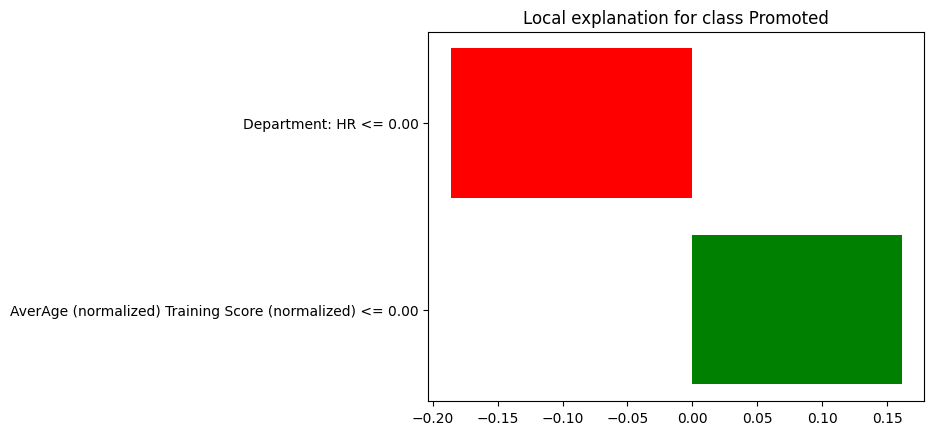

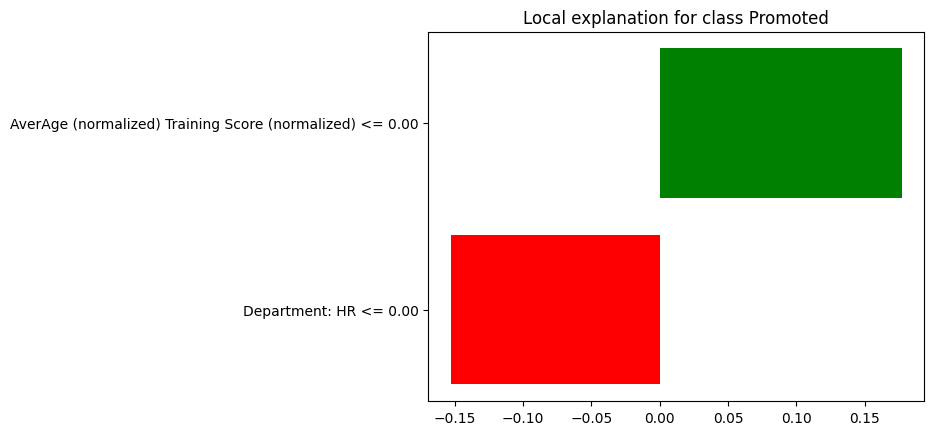

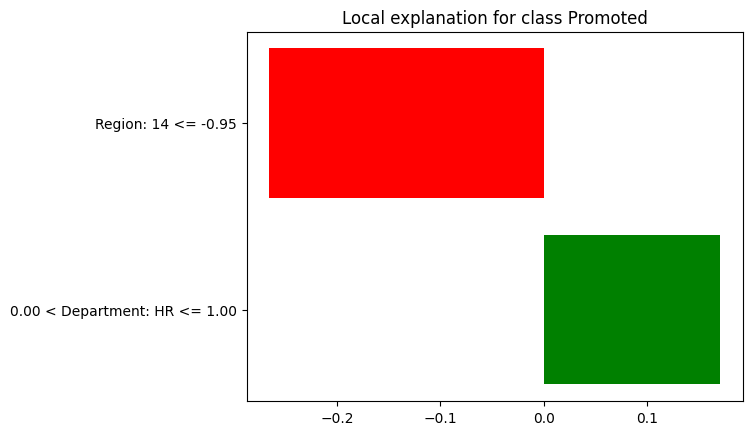

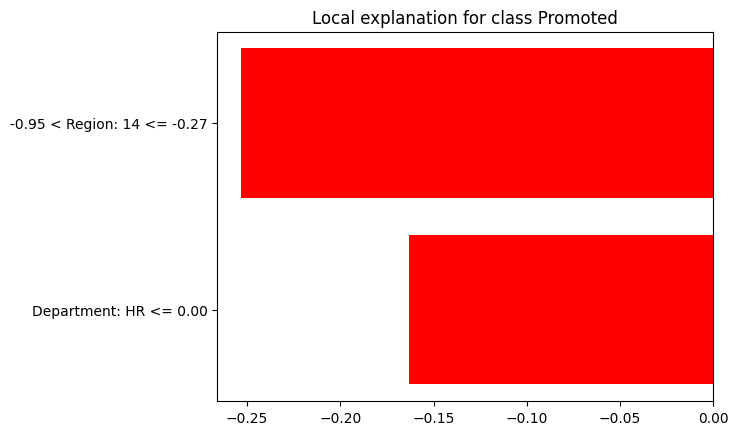

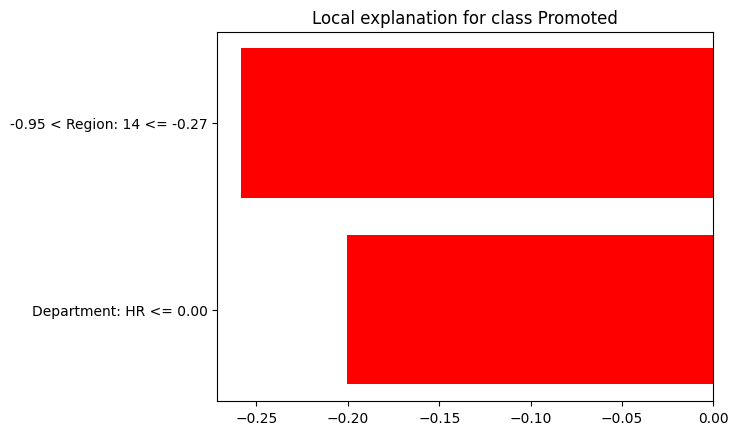

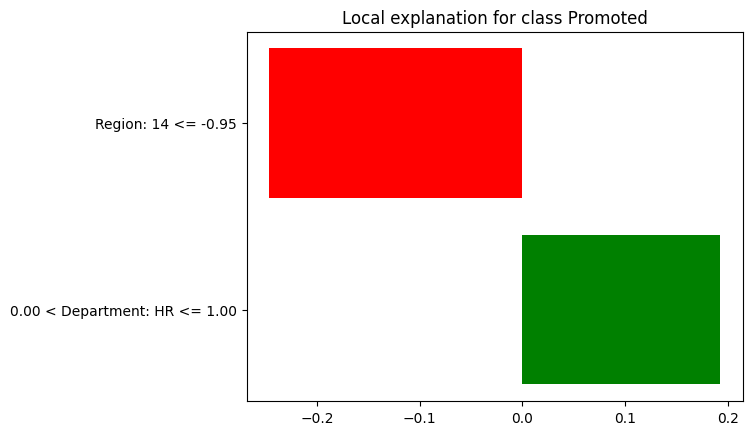

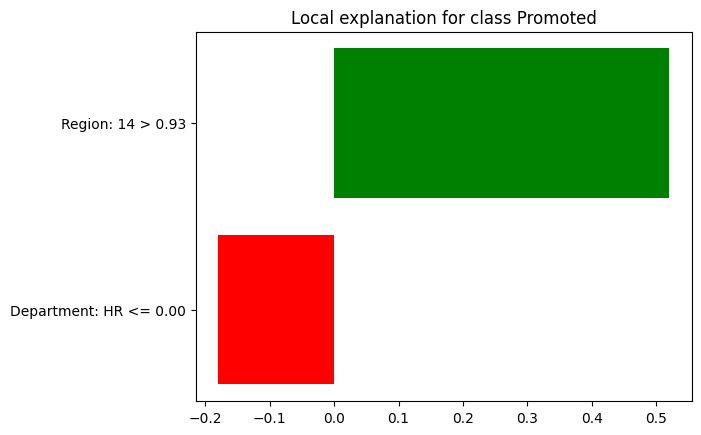

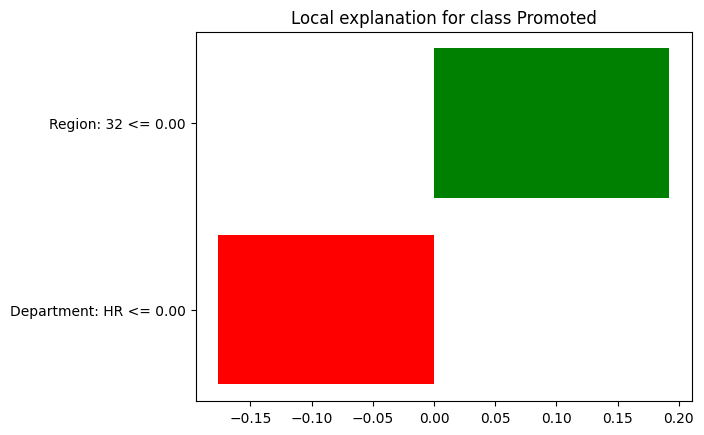

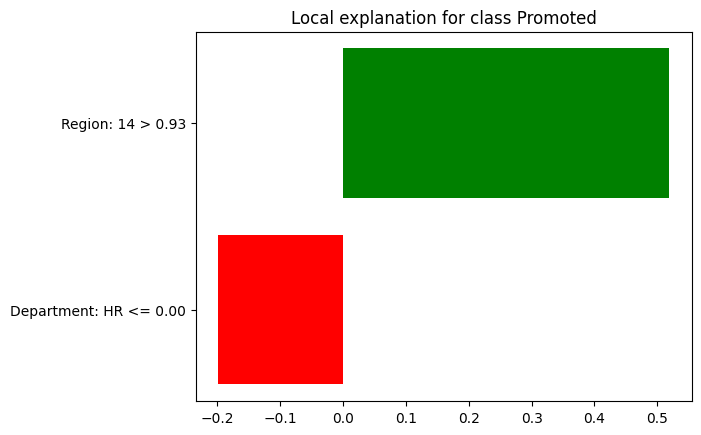

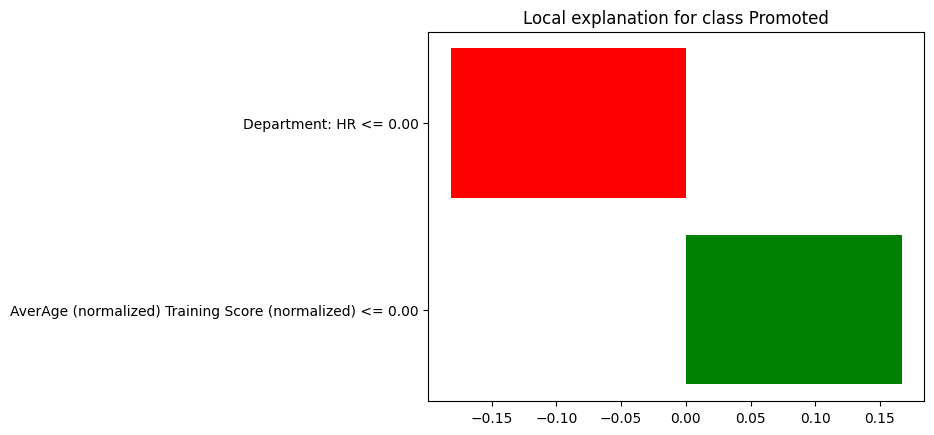

In [128]:
explainer_instance = LIMEExplainer(
    model=model_general,
    feature_names=set(feature_names_cleaned) - set(['gender'])
)
for idx in range(num_instances_to_explain):
    exp, fig = explainer_instance.explain(
        features=['Not Promoted', 'Promoted'],
        testData=X_test_no_gender[idx],
        trainingData=X_train_no_gender
    )
    if not os.path.exists('Explanations'):
        os.makedirs('Explanations')
    fig.savefig(f"Explanations/GENERAL_model_explanation_{idx+1}.png", dpi=300, bbox_inches='tight')

### K-Means Original Model

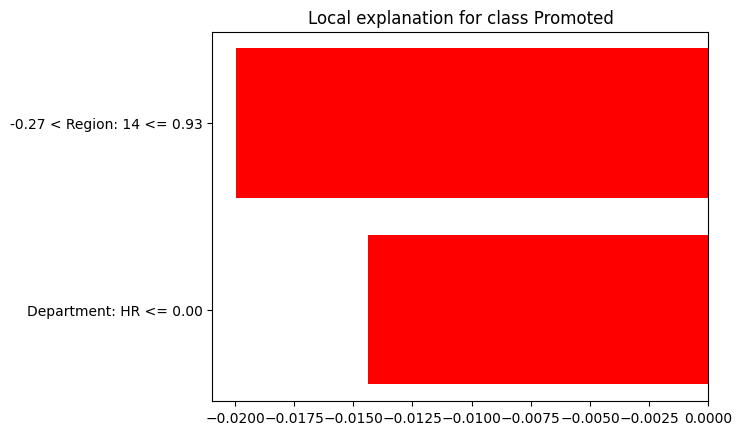

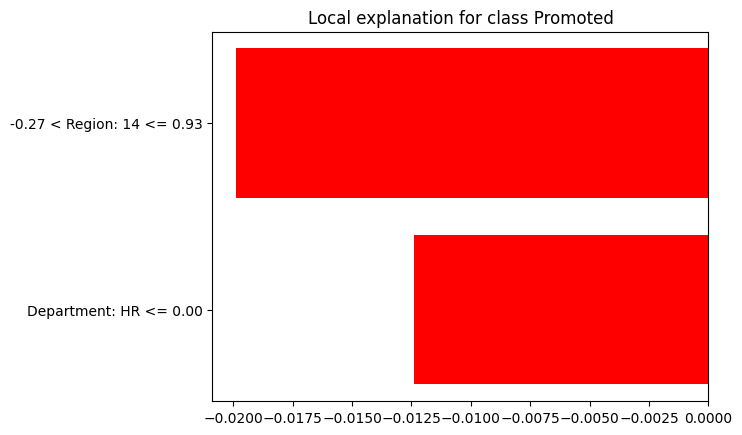

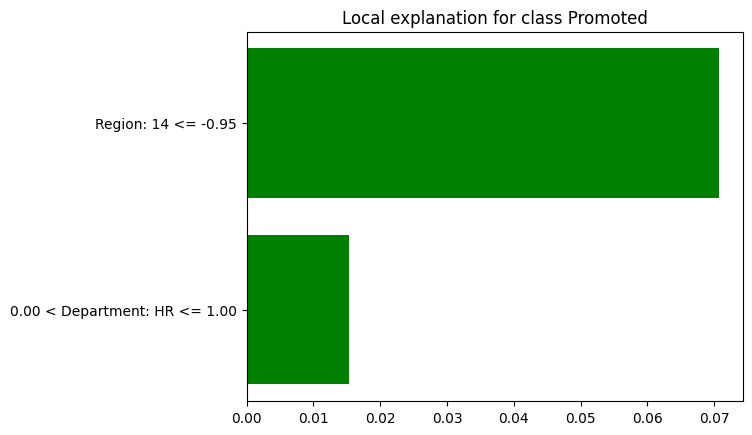

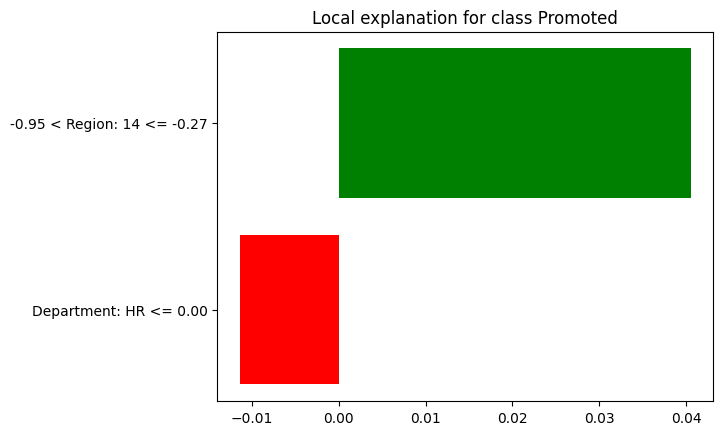

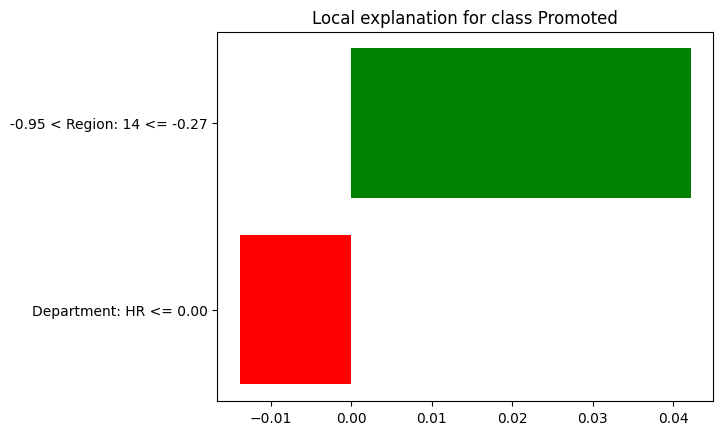

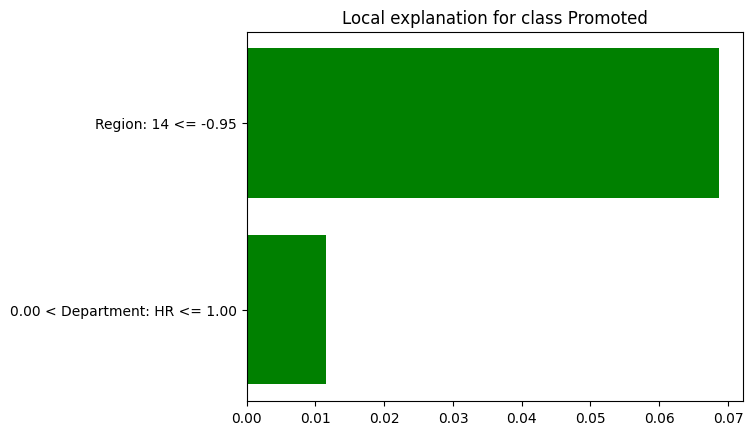

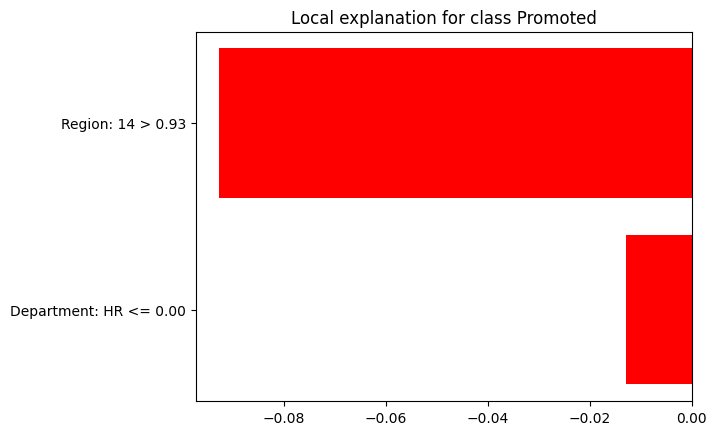

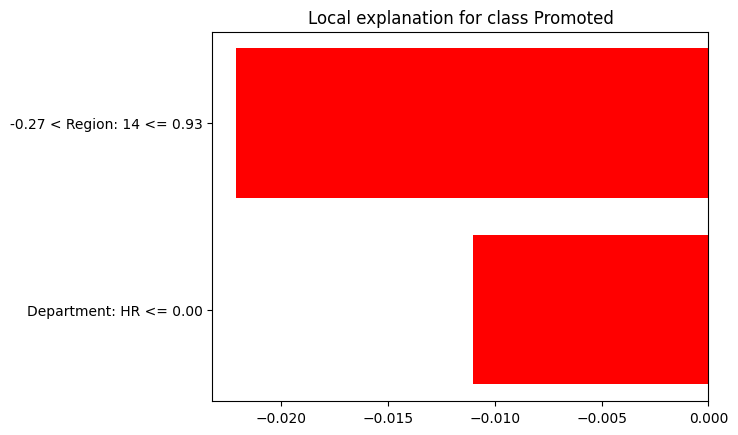

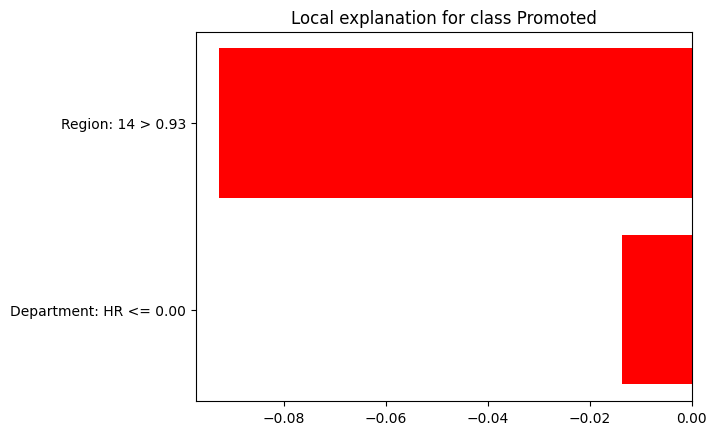

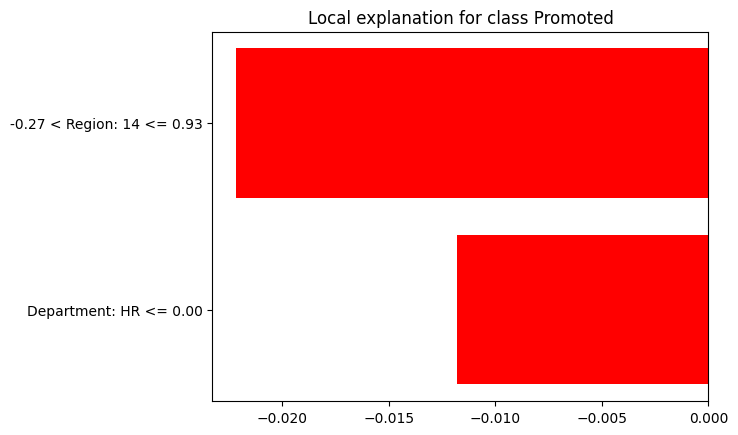

In [141]:
class KMeansWrapper:
    def __init__(self, kmeans_model):
        self.kmeans_model = kmeans_model

    def predict_proba(self, X):
        # Calculate distances to cluster centers
        distances = self.kmeans_model.transform(X)
        # Convert distances to probabilities (inverse of distance)
        probabilities = 1 / (1 + distances)
        # Normalize to make probabilities sum to 1
        return probabilities / probabilities.sum(axis=1, keepdims=True)

# Wrap the KMeans model
model_kmeans_with_proba = KMeansWrapper(model_kmeans)

explainer_instance = LIMEExplainer(
    model=model_kmeans_with_proba,
    feature_names=set(feature_names_cleaned) - set(['gender'])
)
for idx in range(num_instances_to_explain):
    exp, fig = explainer_instance.explain(
        features=['Not Promoted', 'Promoted'],
        testData=X_test_demographic[idx],
        trainingData=X_train_demographic
    )
    if not os.path.exists('Explanations'):
        os.makedirs('Explanations')
    fig.savefig(f"Explanations/KMeans_model_explanation_{idx+1}.png", dpi=300, bbox_inches='tight')

### OOD Clusters

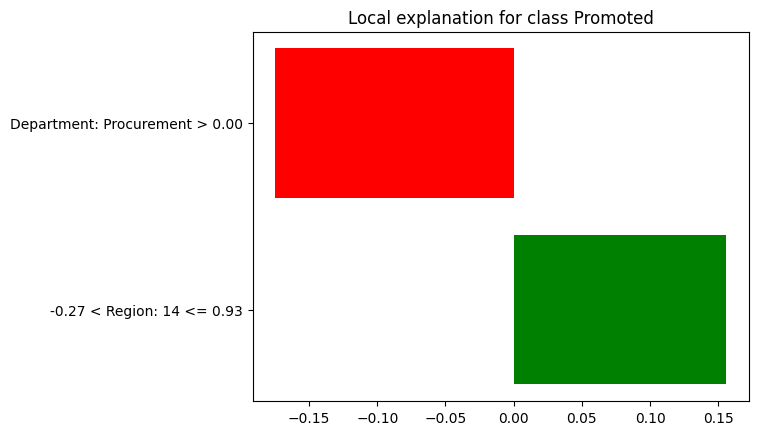

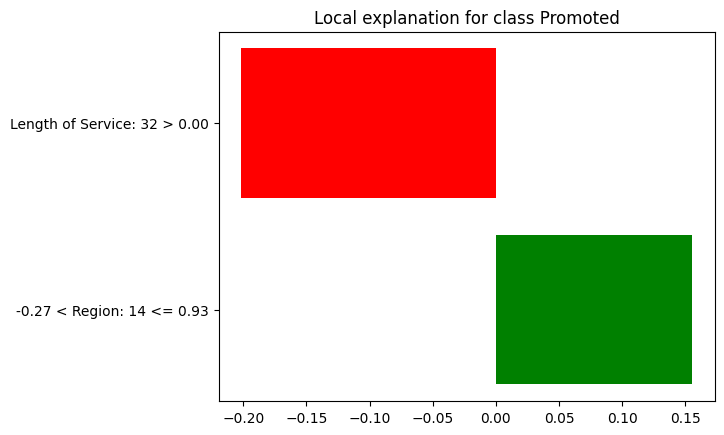

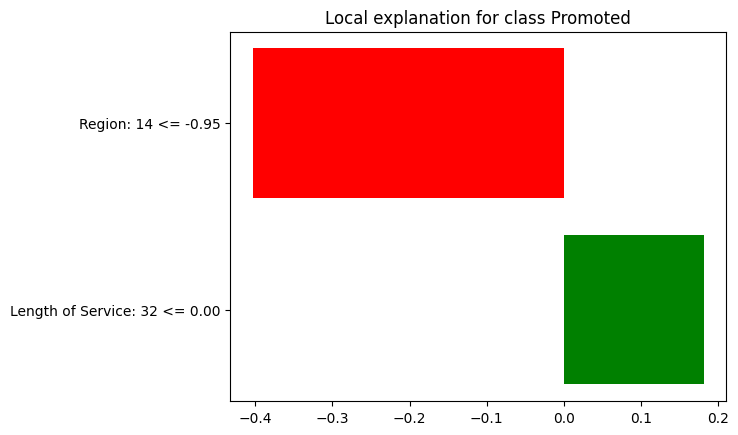

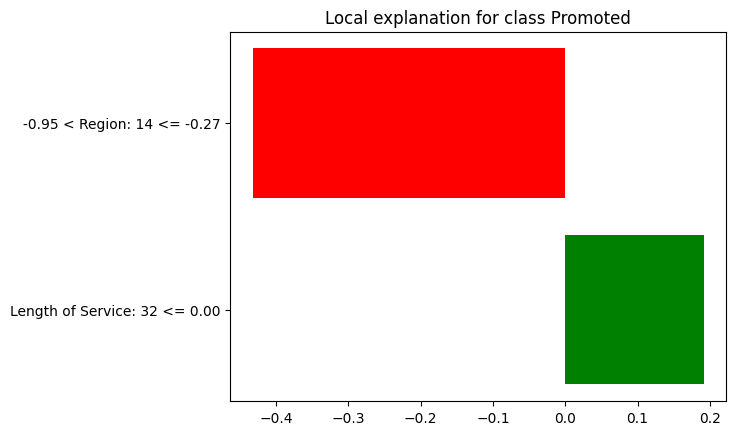

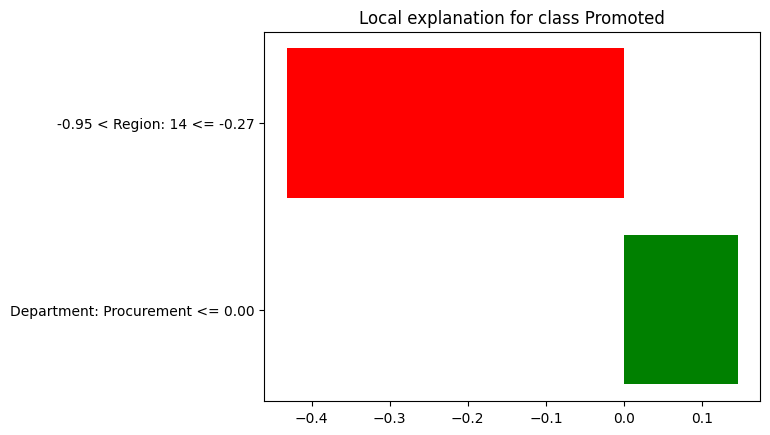

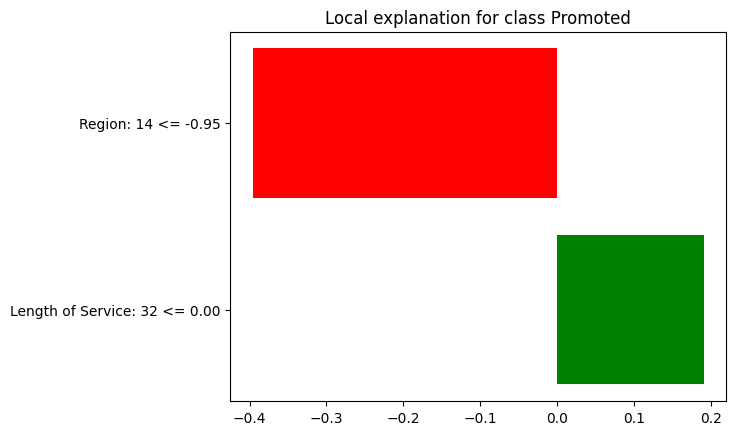

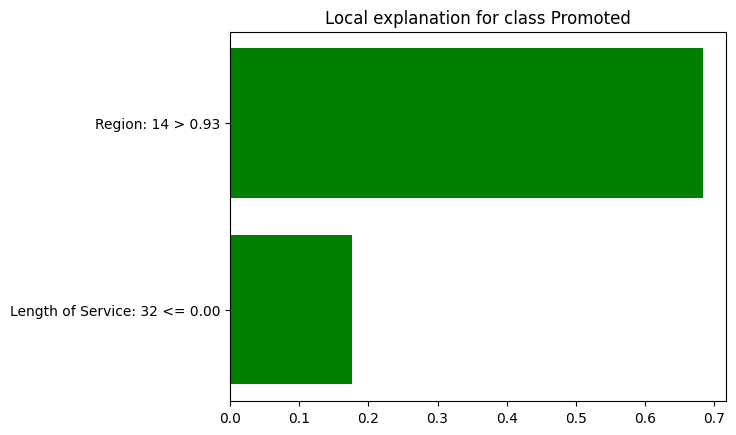

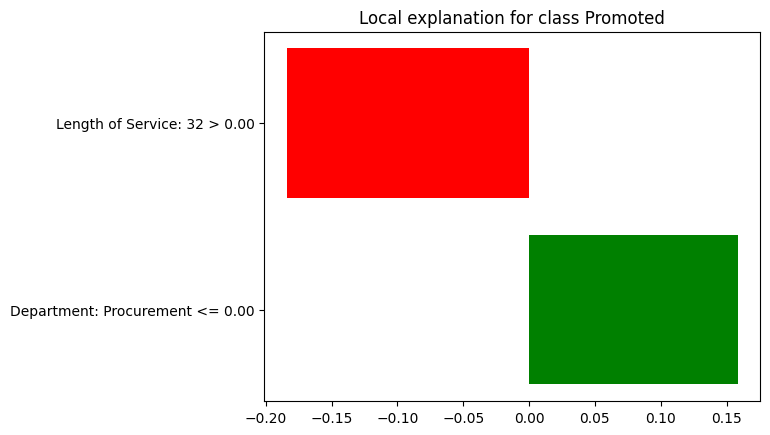

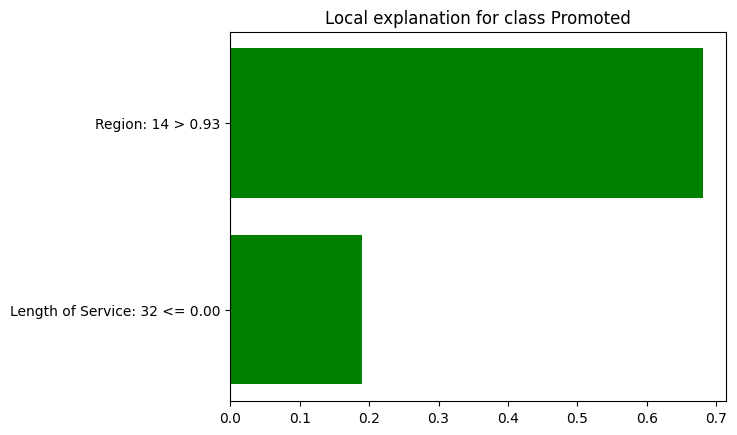

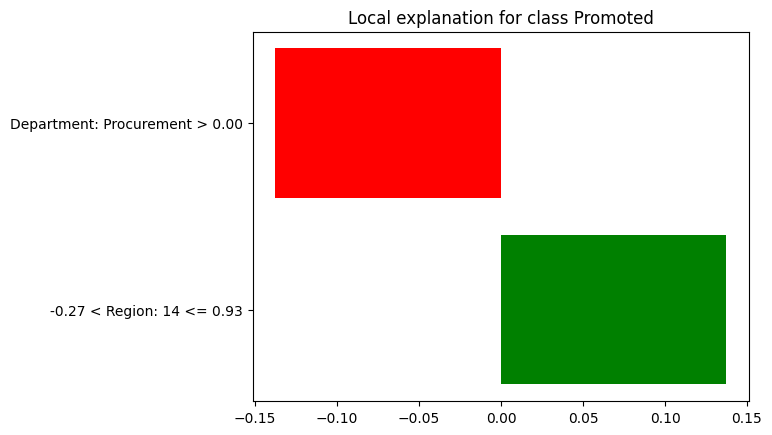

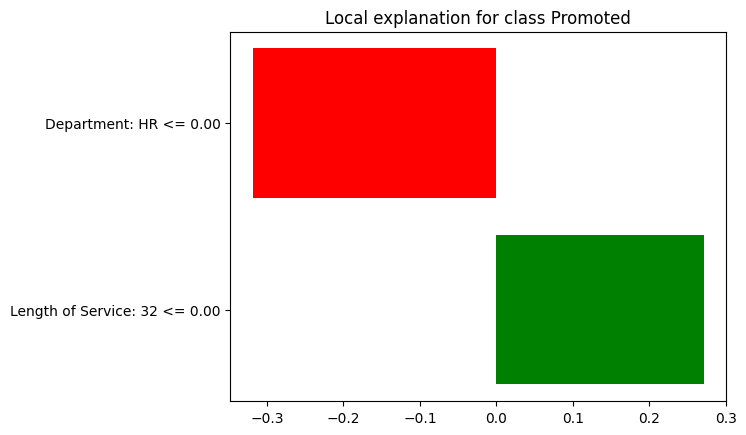

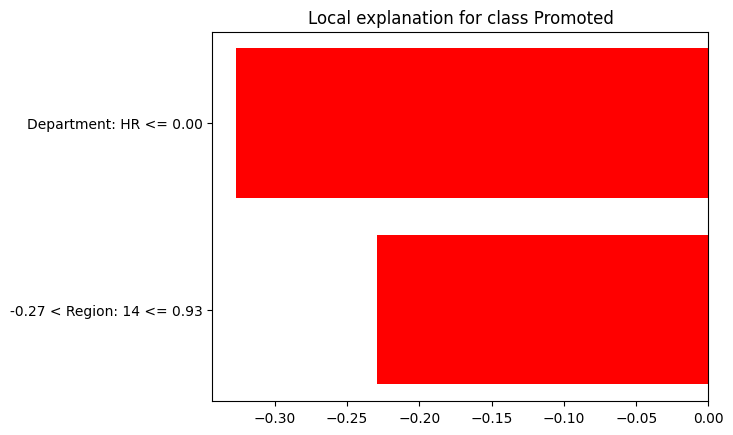

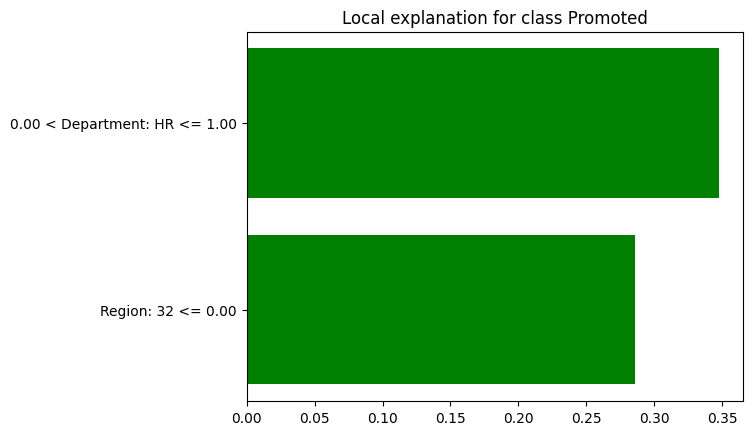

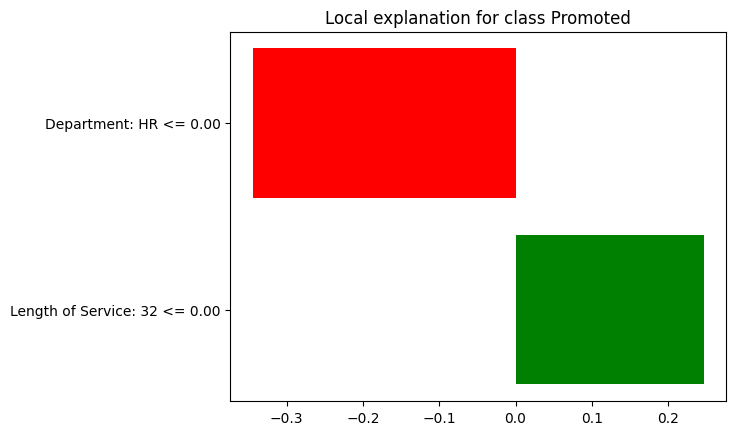

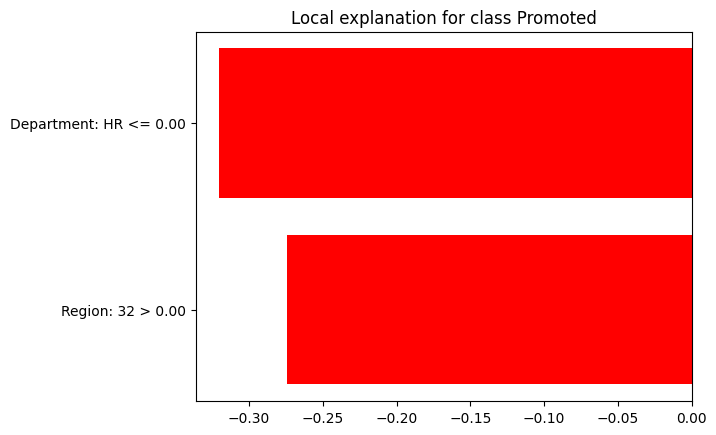

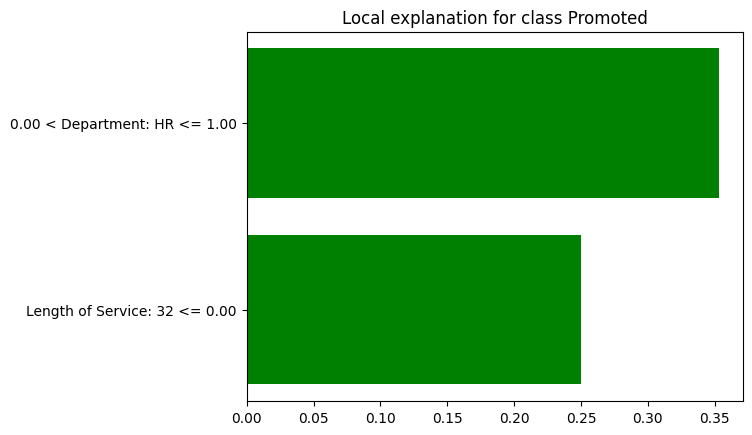

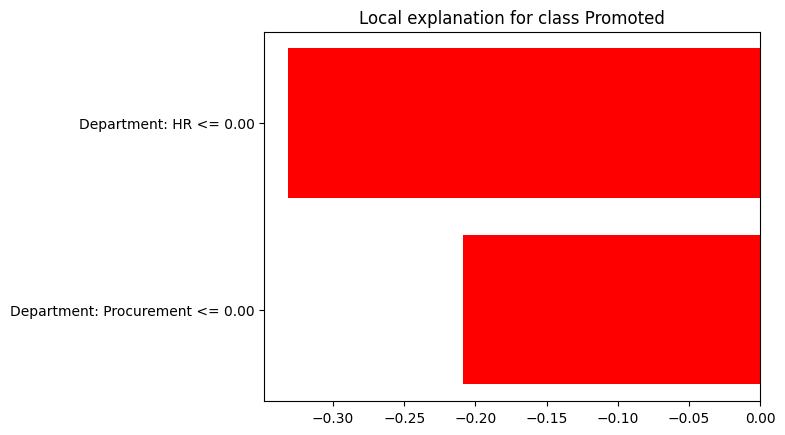

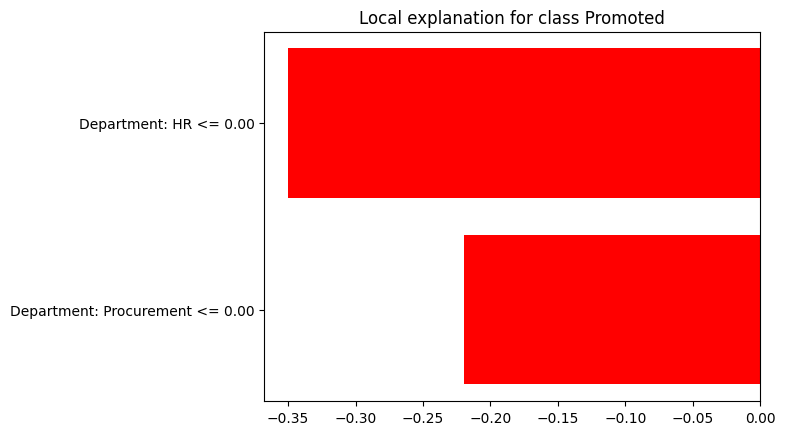

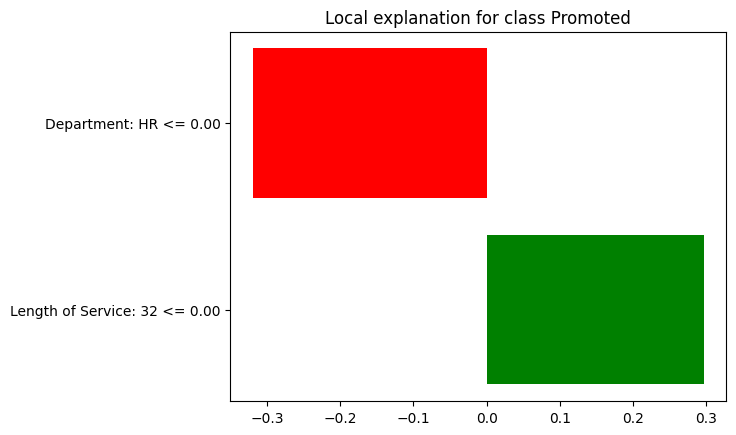

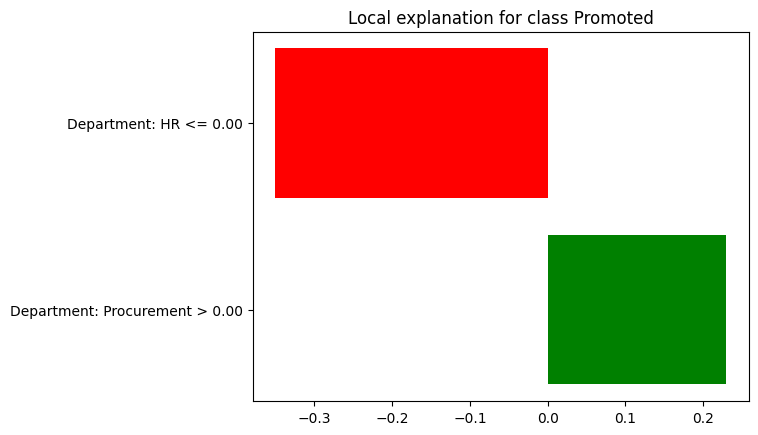

In [138]:
models = [model_cluster_0_OOD, model_cluster_1_OOD]

for modelId, model in enumerate(models):
    explainer_instance = LIMEExplainer(
        model=model,
        feature_names=set(feature_names_cleaned) - set(['gender'])
    )
    for idx in range(num_instances_to_explain):
        exp, fig = explainer_instance.explain(
            features=['Not Promoted', 'Promoted'],
            testData=X_test_no_gender[idx],
            trainingData=X_train_no_gender
        )
        if not os.path.exists('Explanations'):
            os.makedirs('Explanations')
        fig.savefig(f"Explanations/OOD_cluster_{modelId+1}_explanation_{idx+1}.png", dpi=300, bbox_inches='tight')

### K-Means Clusters

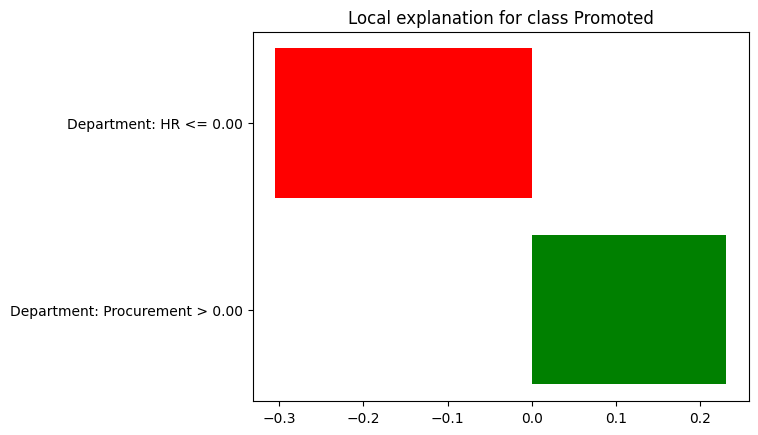

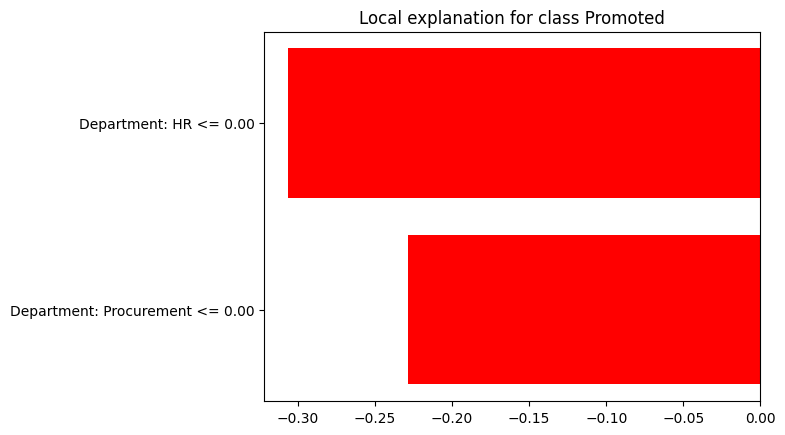

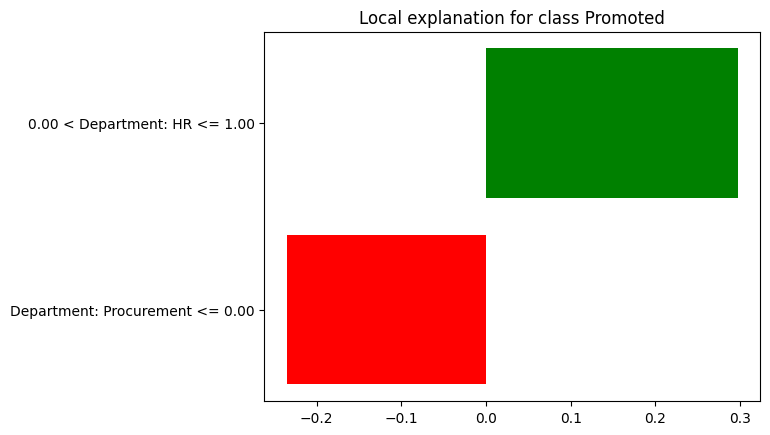

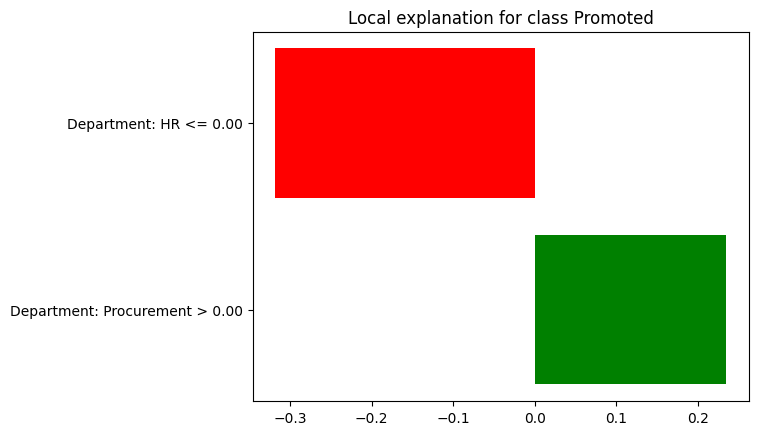

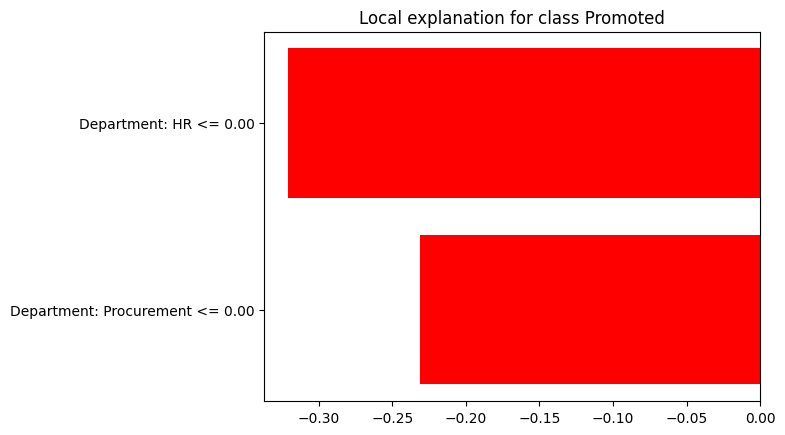

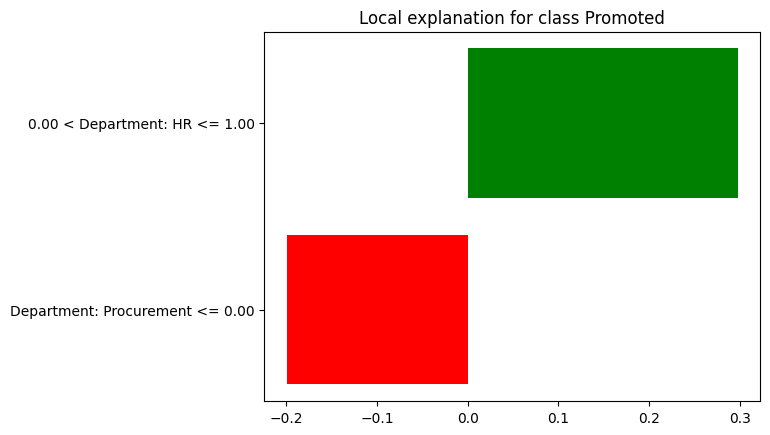

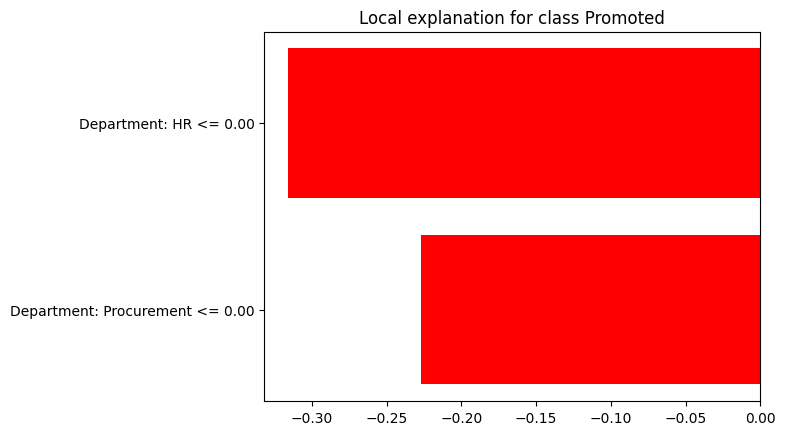

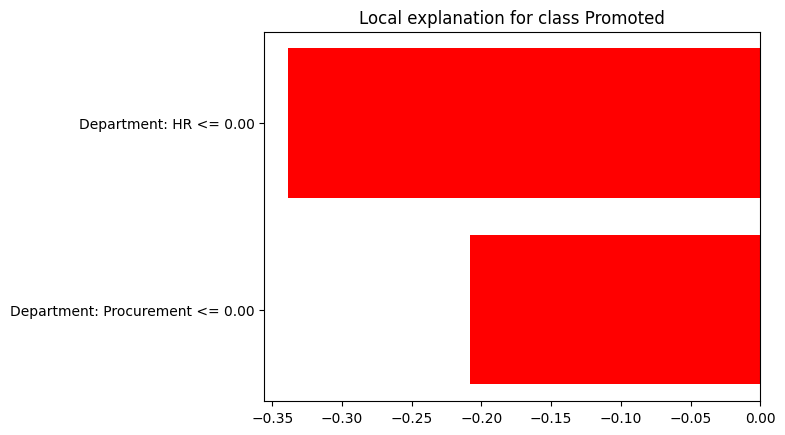

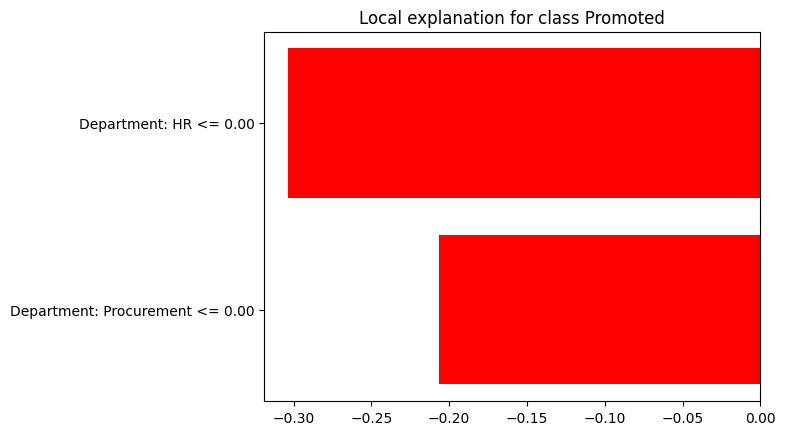

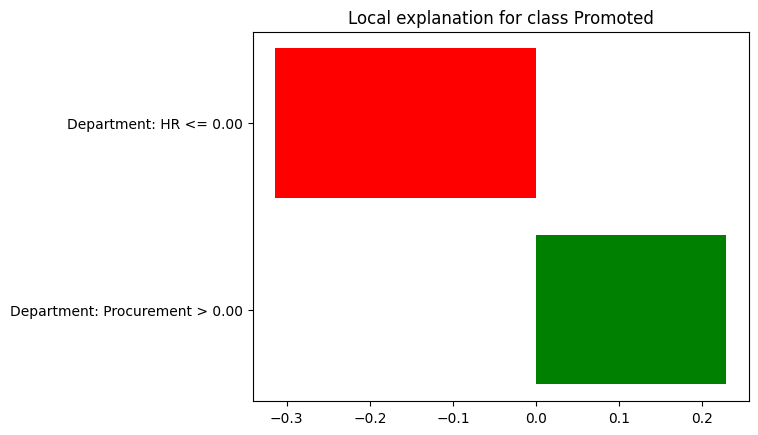

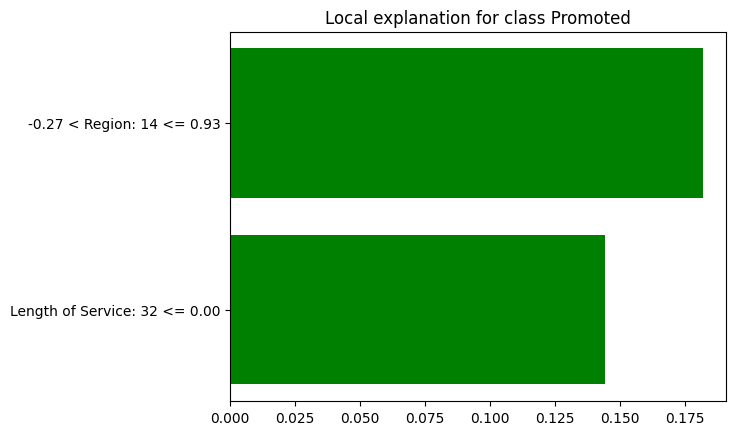

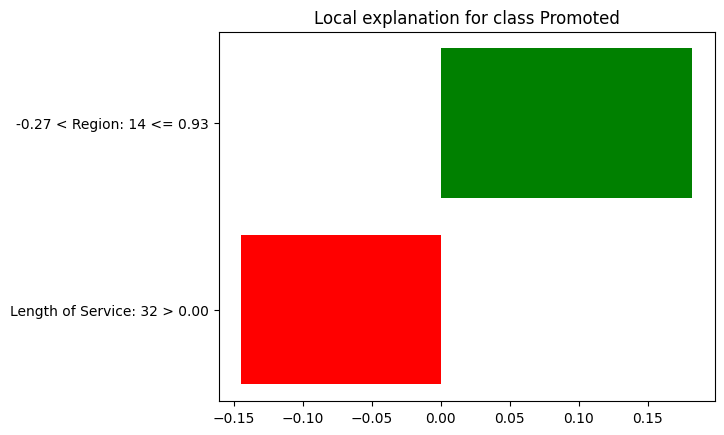

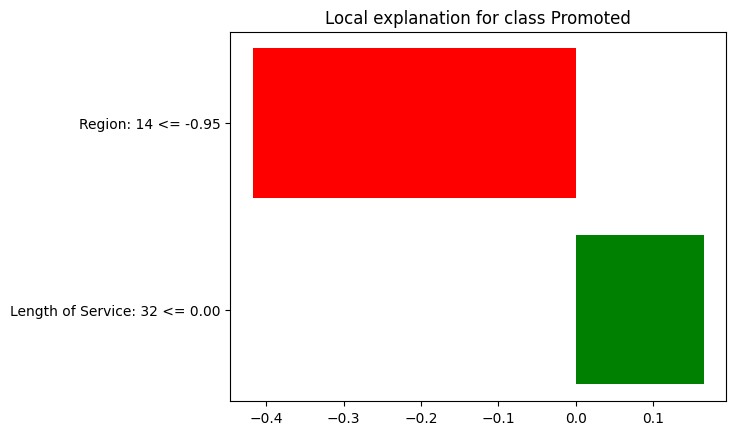

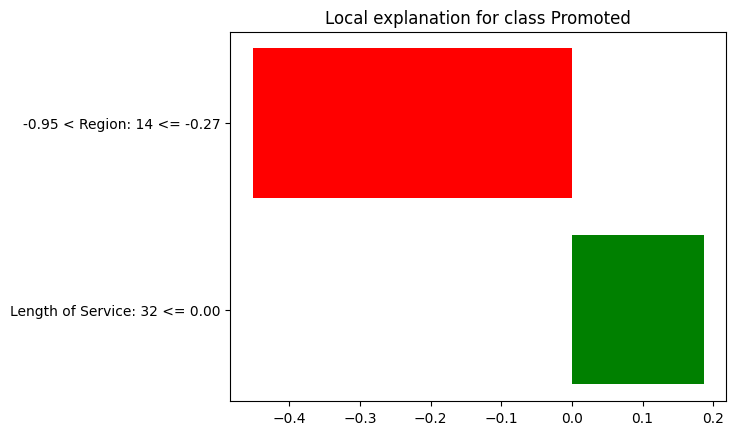

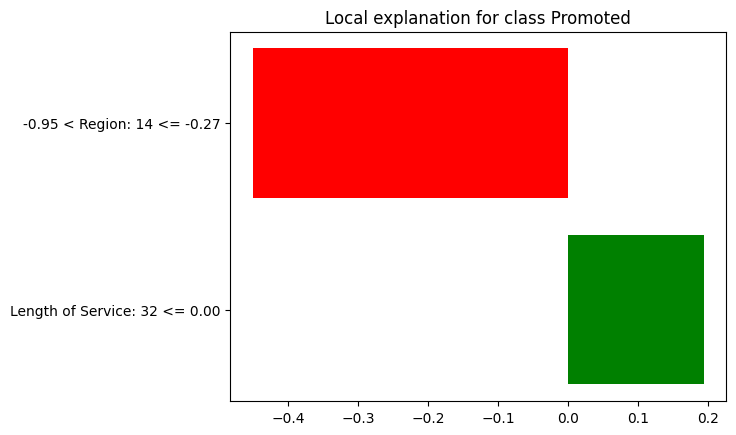

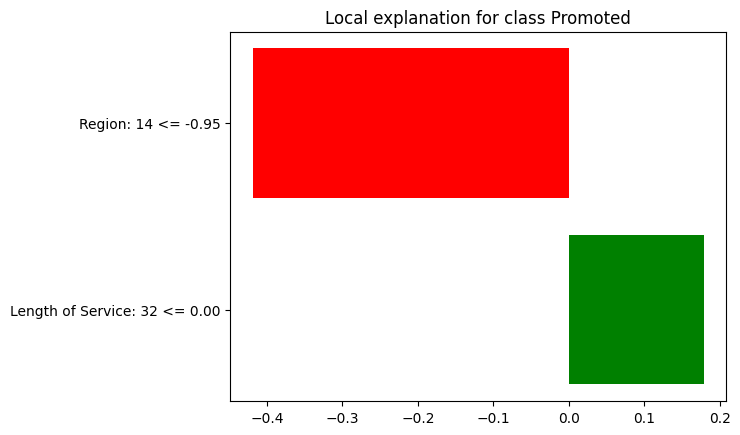

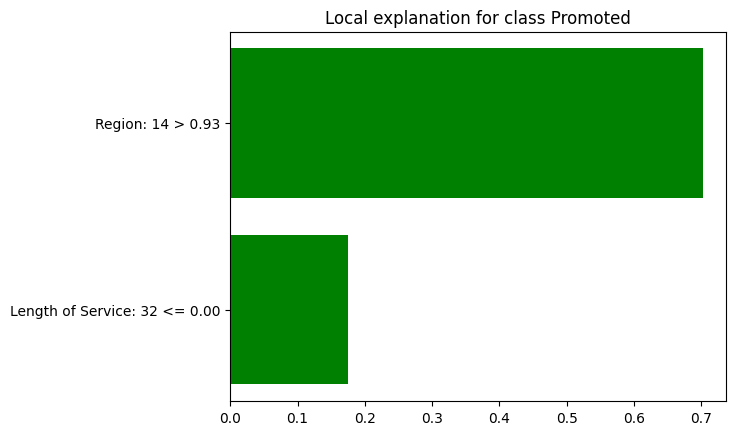

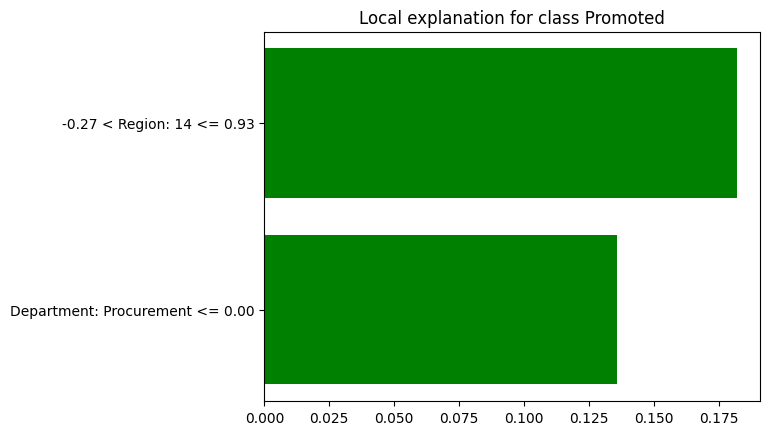

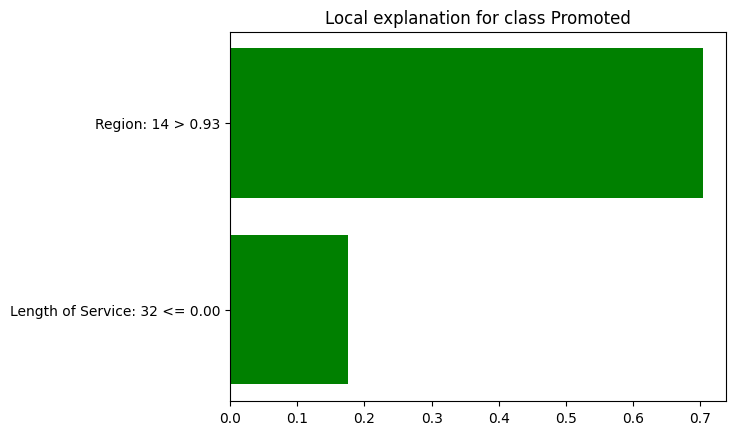

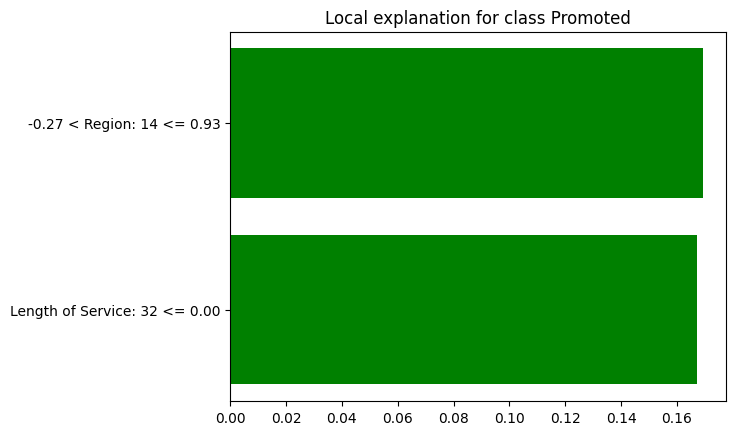

In [142]:
models = [model_cluster_0_kmeans, model_cluster_1_kmeans]

for modelId, model in enumerate(models):
    explainer_instance = LIMEExplainer(
        model=model,
        feature_names=set(feature_names_cleaned) - set(['gender'])
    )
    for idx in range(num_instances_to_explain):
        exp, fig = explainer_instance.explain(
            features=['Not Promoted', 'Promoted'],
            testData=X_test_no_gender[idx],
            trainingData=X_train_no_gender
        )
        if not os.path.exists('Explanations'):
            os.makedirs('Explanations')
        fig.savefig(f"Explanations/KMeans_cluster_{modelId+1}_explanation_{idx+1}.png", dpi=300, bbox_inches='tight')

### OOD Original Model

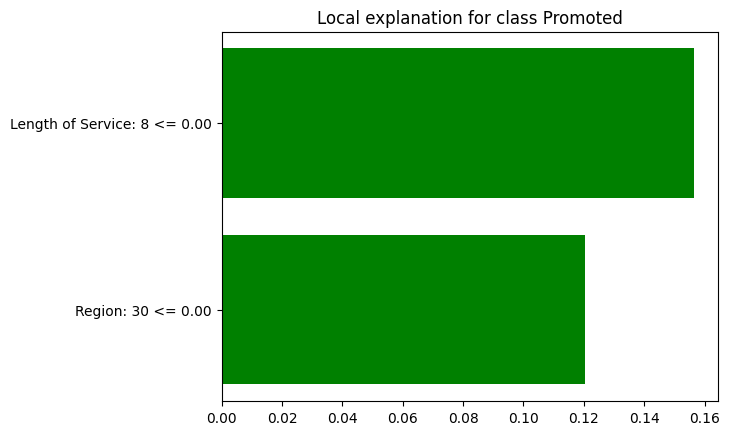

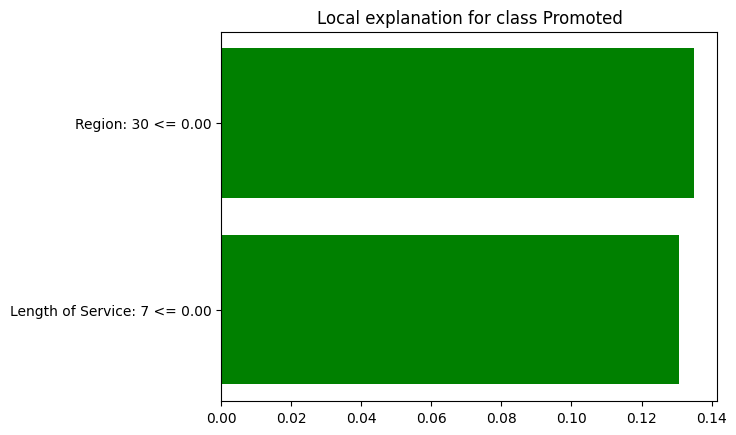

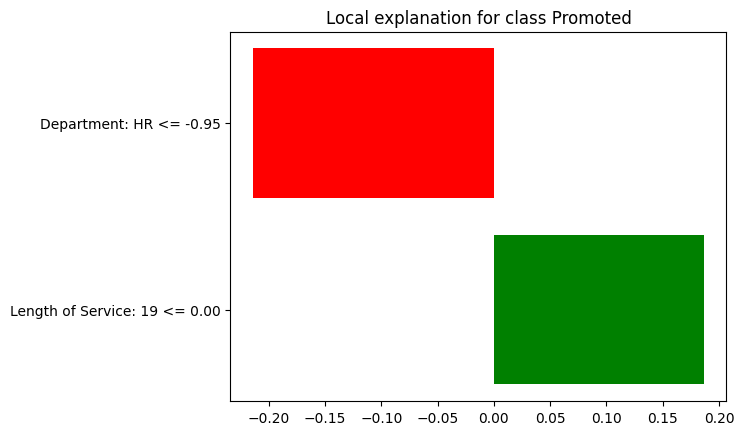

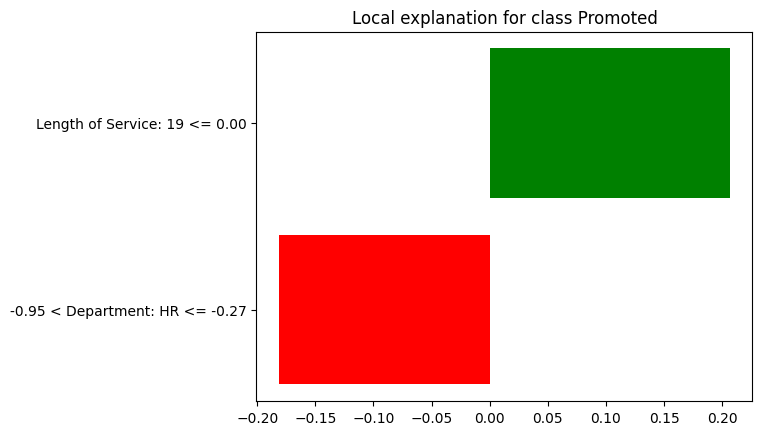

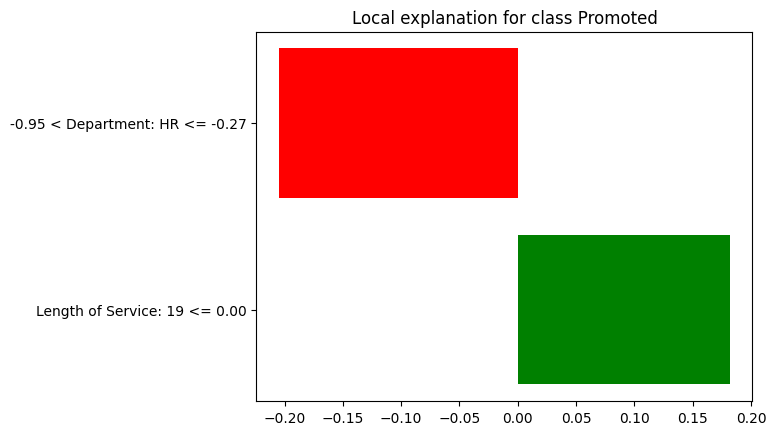

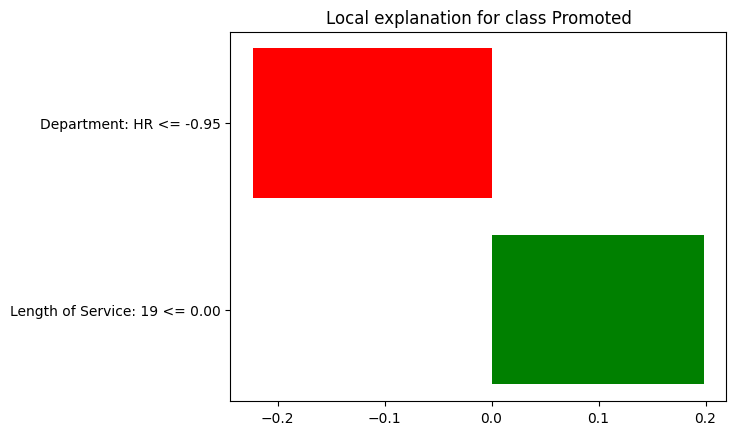

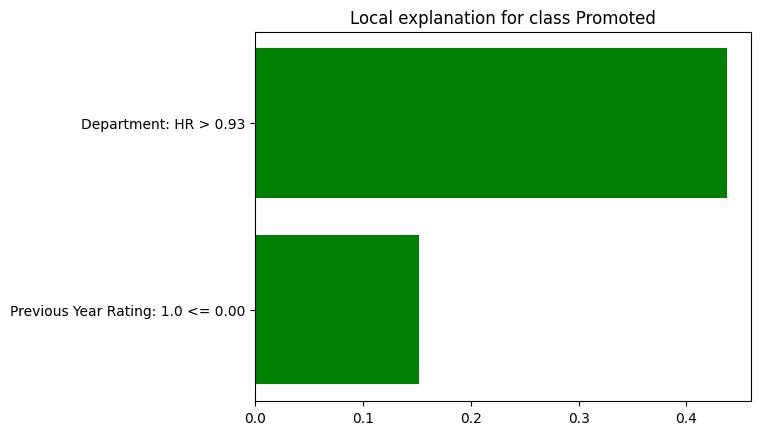

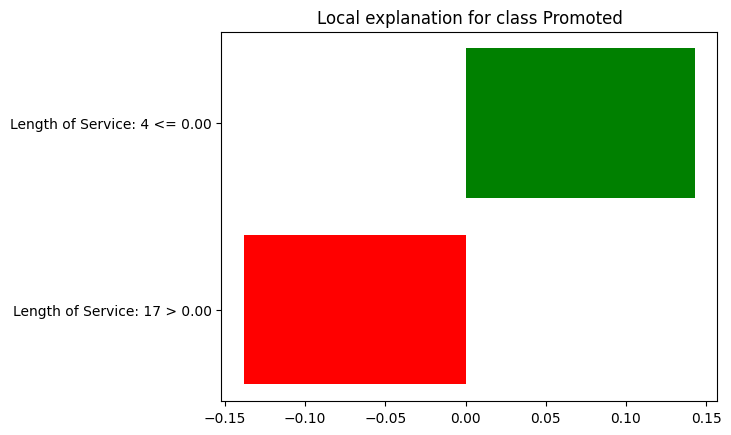

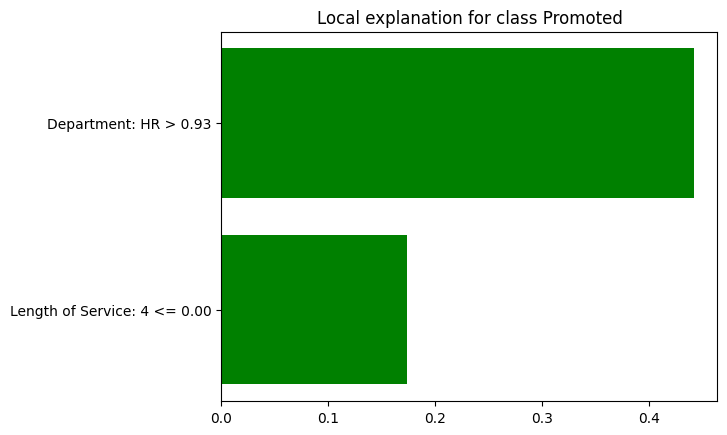

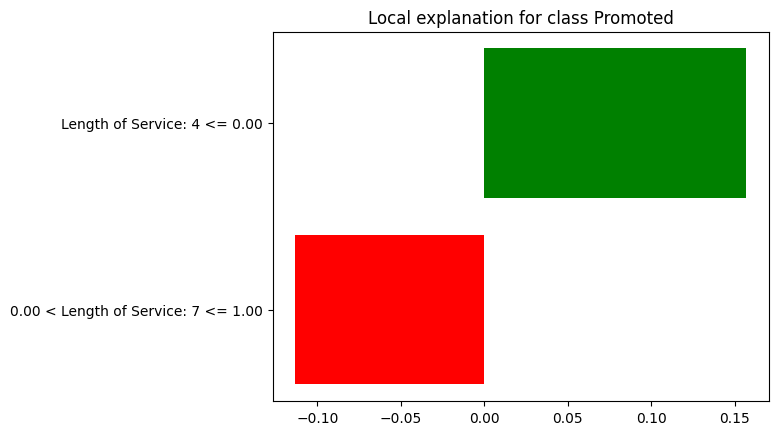

In [144]:
explainer_instance = LIMEExplainer(
    model=model_OOD,
    feature_names=set(feature_names_cleaned) - set(['gender'])
)
for idx in range(num_instances_to_explain):
    exp, fig = explainer_instance.explain(
        features=['Not Promoted', 'Promoted'],
        testData=X_test_norm[idx],
        trainingData=X_train_norm
    )
    if not os.path.exists('Explanations'):
        os.makedirs('Explanations')
    fig.savefig(f"Explanations/OOD_model_explanation_{idx+1}.png", dpi=300, bbox_inches='tight')

### New Approach: K-Means with OOD

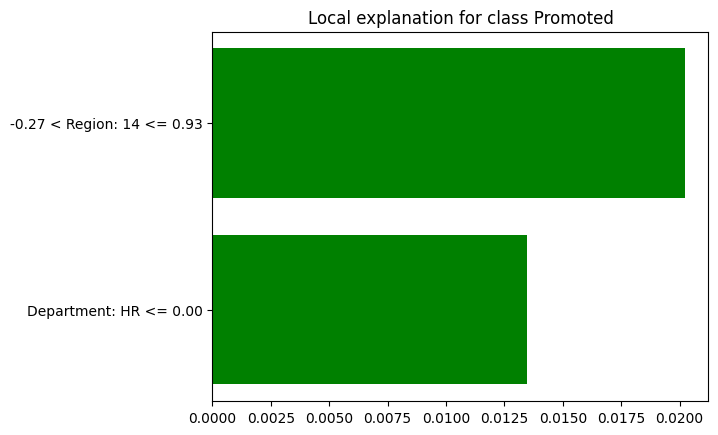

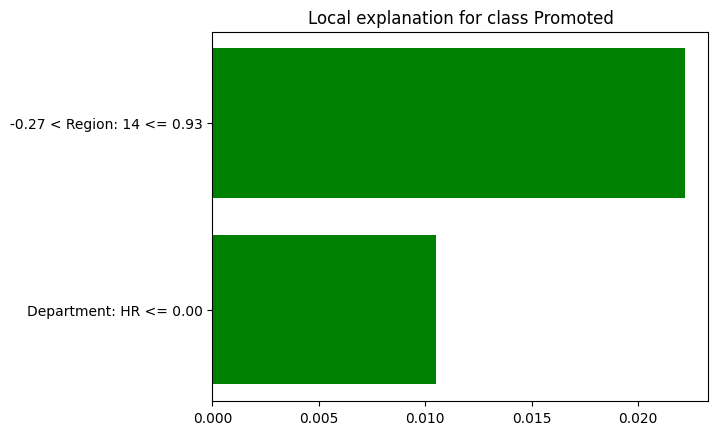

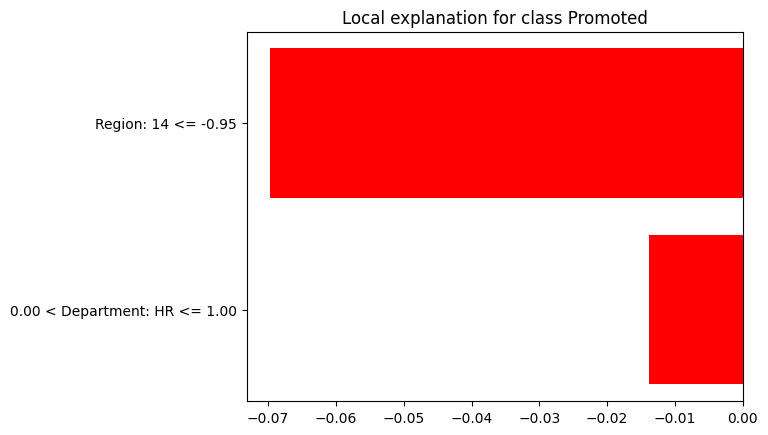

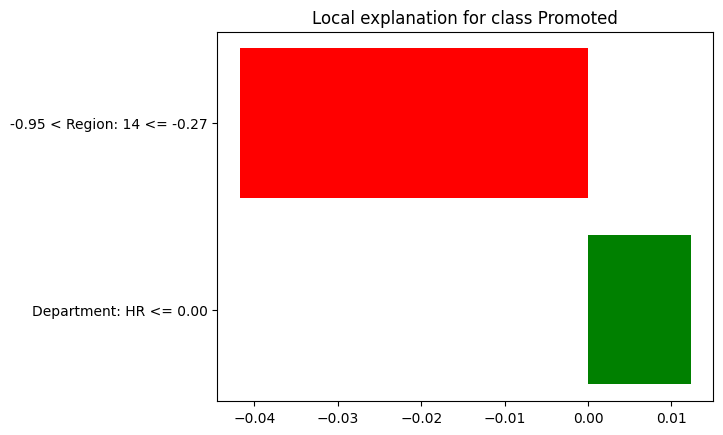

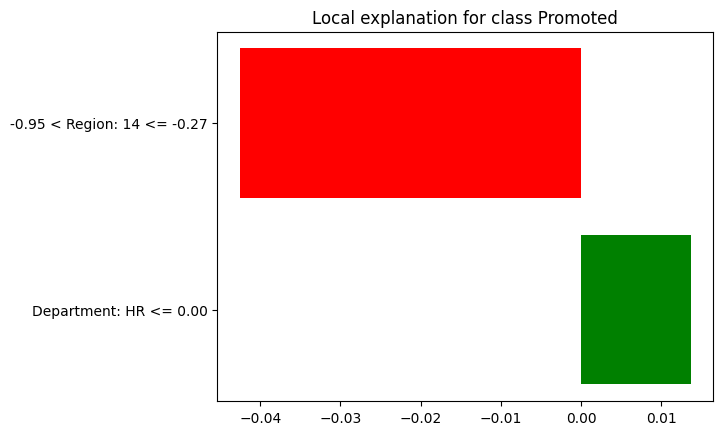

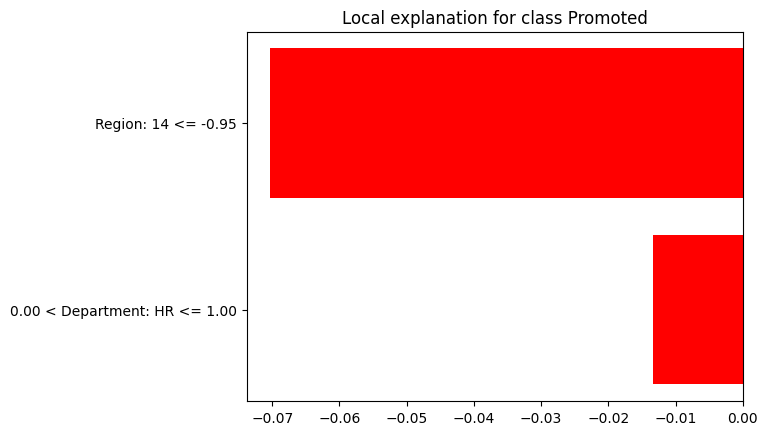

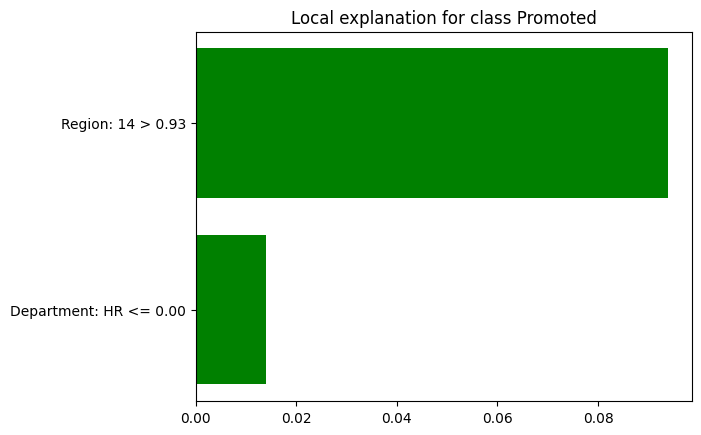

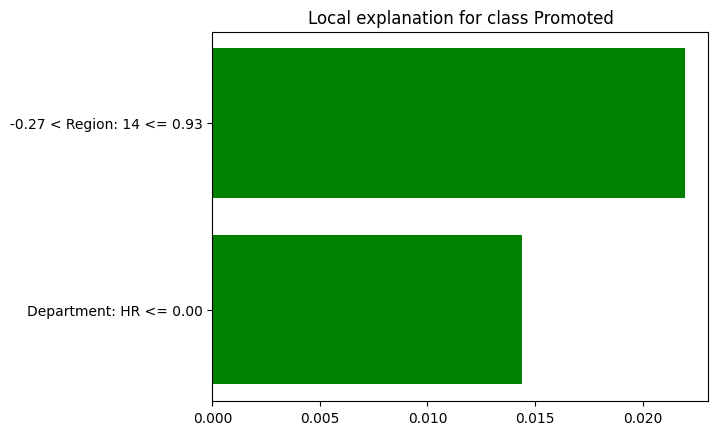

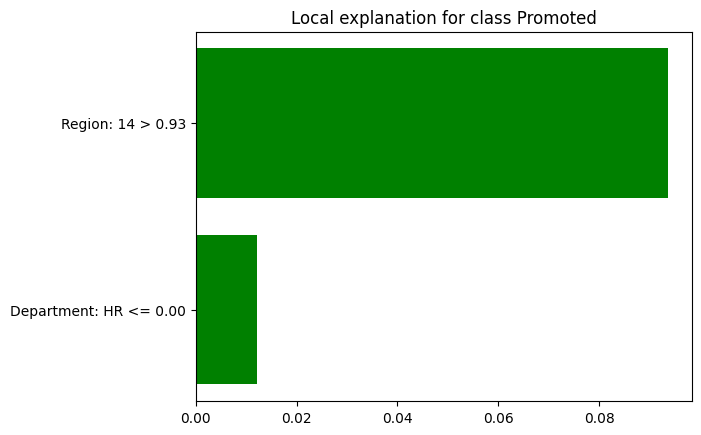

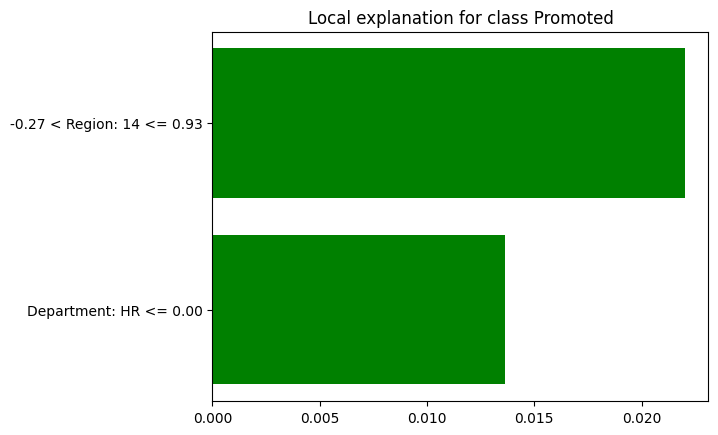

In [147]:
# Wrap the KMeans OOD model
model_kmeans_OOD_with_proba = KMeansWrapper(model_kmeans_OOD)

explainer_instance = LIMEExplainer(
    model=model_kmeans_OOD_with_proba,
    feature_names=set(feature_names_cleaned) - set(['gender'])
)
for idx in range(num_instances_to_explain):
    exp, fig = explainer_instance.explain(
        features=['Not Promoted', 'Promoted'],
        testData=X_test_demographic[idx],
        trainingData=X_train_demographic
    )
    if not os.path.exists('Explanations'):
        os.makedirs('Explanations')
    fig.savefig(f"Explanations/KMeans_OOD_model_explanation_{idx+1}.png", dpi=300, bbox_inches='tight')